## GBDT Xgboost LightGBM对比


# Mnist数据集识别
### 使用Sklearn的GBDT

[GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

[GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [1]:
import gzip
import pickle as pkl
from sklearn.model_selection import train_test_split

def load_data(path):
    f = gzip.open(path, 'rb')
    try:
        #Python3
        train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    except:
        #Python2
        train_set, valid_set, test_set = pkl.load(f)
    f.close()
    return(train_set,valid_set,test_set)

path = 'mnist.pkl.gz' 
train_set,valid_set,test_set = load_data(path)

Xtrain,_,ytrain,_ = train_test_split(train_set[0], train_set[1], test_size=0.9)
Xtest,_,ytest,_ = train_test_split(test_set[0], test_set[1], test_size=0.9)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(5000, 784) (5000,) (1000, 784) (1000,)


参数说明：

- **learning_rate**: The learning parameter controls the magnitude of this change in the estimates. (default=0.1)
- **n_extimators**: The number of sequential trees to be modeled. (default=100)
- **max_depth**: The maximum depth of a tree. (default=3)
- **min_samples_split**: Tthe minimum number of samples (or observations) which are required in a node to be considered for splitting. (default=2)
- **min_samples_leaf**: The minimum samples (or observations) required in a terminal node or leaf. (default=1)
- **min_weight_fraction_leaf**: Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer. (default=0.)
- **subsample**: The fraction of observations to be selected for each tree. Selection is done by random sampling. (default=1.0)
- **max_features**: The number of features to consider while searching for a best split. These will be randomly selected. (default=None)
- **max_leaf_nodes**: The maximum number of terminal nodes or leaves in a tree. (default=None)
- **min_impurity_decrease**: A node will be split if this split induces a decrease of the impurity greater than or equal to this value. (default=0.)


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import time 

clf = GradientBoostingClassifier(n_estimators=10, 
                                 learning_rate=0.1, 
                                 max_depth=3)

# start training
start_time = time.time()
clf.fit(Xtrain, ytrain)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# prediction and evaluation 
pred = clf.predict(Xtest)
accuracy = np.sum(pred == ytest) / pred.shape[0]
print('Test accuracy = {}'.format(accuracy))

The training time = 11.989675521850586
Test accuracy = 0.825


集成算法可以得出特征重要性，说白了就是看各个树使用特征的情况，使用的多当然就重要了,这是分类器告诉我们的。

0.0249318971528 0.0


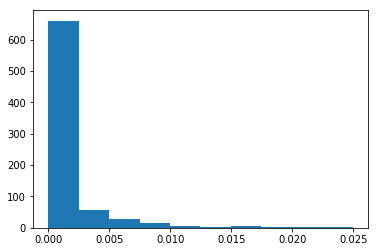

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(clf.feature_importances_)
print(max(clf.feature_importances_), min(clf.feature_importances_))

一般情况下，我们还可以筛选一下。 

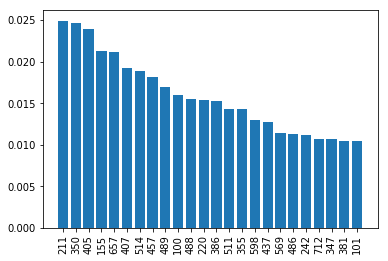

In [4]:
from collections import OrderedDict
d = {}
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0.01:
        d[i] = clf.feature_importances_[i]

sorted_feature_importances = OrderedDict(sorted(d.items(), key=lambda x:x[1], reverse=True))
D = sorted_feature_importances
rects = plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys(),rotation=90)
plt.show()

由于是像素点，所以看的没那么直观，正常特征看起来其实蛮直接的。

## XGBoost

加入了更多的剪枝策略和正则项，控制过拟合风险。传统的GBDT用的是CART，Xgboost能支持的分类器更多，也可以是线性的。GBDT只用了一阶导，但是xgboost对损失函数做了二阶的泰勒展开，并且还可以自定义损失函数。



<img src="https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/struct_score.png" width="500" height="500" />

 


In [5]:
import xgboost as xgb
import numpy as np
import time

# read data into Xgboost DMatrix format
dtrain = xgb.DMatrix(Xtrain, label=ytrain)
dtest = xgb.DMatrix(Xtest, label=ytest)

# specify parameters via map
params = {
    'booster':'gbtree',     #  tree-based models
    'objective': 'multi:softmax', 
    'num_class':10, 
    'eta': 0.1,             # Same to learning rate
    'gamma':0,              # Similar to min_impurity_decrease in GBDT
    'alpha': 0,             # L1 regularization term on weight (analogous to Lasso regression)
    'lambda': 2,            # L2 regularization term on weights (analogous to Ridge regression)
    'max_depth': 3,         # Same as the max_depth of GBDT
    'subsample': 1,         # Same as the subsample of GBDT
    'colsample_bytree': 1,  # Similar to max_features in GBM
    'min_child_weight': 1,  # minimum sum of instance weight (Hessian) needed in a child
    'nthread':1,            # default to maximum number of threads available if not set
}
num_round = 10

# start training
start_time = time.time()
bst = xgb.train(params, dtrain, num_round)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# get prediction and evaluate
ypred = bst.predict(dtest)
accuracy = np.sum(ypred == ytest) / ypred.shape[0]
print('Test accuracy = {}'.format(accuracy))


The training time = 13.496984481811523
Test accuracy = 0.821


 [Xgboost参数](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

## LightGBM

放到最后肯定有一堆优点的：

- 更快的训练效率

- 低内存使用

- 更好的准确率

- 支持并行学习

- 可处理大规模数据

它摒弃了现在大部分GBDT使用的按层生长（level-wise）的决策树生长策略，使用带有深度限制的按叶子生长（leaf-wise）的策略。level-wise过一次数据可以同时分裂同一层的叶子，容易进行多线程优化，也好控制模型复杂度，不容易过拟合。但实际上level-wise是一种低效的算法，因为它不加区分的对待同一层的叶子，带来了很多没必要的开销，因为实际上很多叶子的分裂增益较低，没必要进行搜索和分裂。 

Leaf-wise则是一种更为高效的策略，每次从当前所有叶子中，找到分裂增益最大的一个叶子，然后分裂，如此循环。因此同Level-wise相比，在分裂次数相同的情况下，Leaf-wise可以降低更多的误差，得到更好的精度。Leaf-wise的缺点是可能会长出比较深的决策树，产生过拟合。因此LightGBM在Leaf-wise之上增加了一个最大深度的限制，在保证高效率的同时防止过拟合。 

<img src="https://lightgbm.readthedocs.io/en/latest/_images/level-wise.png" width="400" height="400" />
<img src="https://lightgbm.readthedocs.io/en/latest/_images/leaf-wise.png" width="500" height="500" />



 [安装指引](https://github.com/Microsoft/LightGBM/tree/master/python-package)


In [8]:
import lightgbm as lgb
train_data = lgb.Dataset(Xtrain, label=ytrain)
test_data = lgb.Dataset(Xtest, label=ytest)

# specify parameters via map
params = {
    'num_leaves':31,                # Same to max_leaf_nodes in GBDT, but GBDT's default value is None
    'max_depth': -1,                # Same to max_depth of xgboost
    'tree_learner': 'serial', 
    'application':'multiclass',     # Same to objective of xgboost
    'num_class':10,                 # Same to num_class of xgboost
    'learning_rate': 0.1,           # Same to eta of xgboost
    'min_split_gain': 0,            # Same to gamma of xgboost
    'lambda_l1': 0,                 # Same to alpha of xgboost
    'lambda_l2': 0,                 # Same to lambda of xgboost
    'min_data_in_leaf': 20,         # Same to min_samples_leaf of GBDT
    'bagging_fraction': 1.0,        # Same to subsample of xgboost
    'bagging_freq': 0,
    'bagging_seed': 0,
    'feature_fraction': 1.0,         # Same to colsample_bytree of xgboost
    'feature_fraction_seed': 2,
    'min_sum_hessian_in_leaf': 1e-3, # Same to min_child_weight of xgboost
    'num_threads': 1
}
num_round = 10

# start training
start_time = time.time()
bst = lgb.train(params, train_data, num_round)
end_time = time.time()
print('The training time = {}'.format(end_time - start_time))

# get prediction and evaluate
ypred_onehot = bst.predict(Xtest)
ypred = []
for i in range(len(ypred_onehot)):
    ypred.append(ypred_onehot[i].argmax())

accuracy = np.sum(ypred == ytest) / len(ypred)
print('Test accuracy = {}'.format(accuracy))

The training time = 4.891559839248657
Test accuracy = 0.902


 [参数解释](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst) 

## 结果对比
 

|          | time(s) | accuracy(%) |
|----------|---------|-------------|
| GBDT     | 11.98   | 0.825       |
| XGBoost  | 13.49   | 0.821       |
| LightGBM | 4.89    | 0.902       |



http://lightgbm.apachecn.org/cn/latest/Parameters-Tuning.html